# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:** Anoushka Yadav
**`Roll Number`:** U20230076
**`GitHub Branch`:** anoushka_U20230076

# Imports and Setup

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from rlcmab_sampler import sampler

# Seed for reproducibility
np.random.seed(42)

# Load Datasets

In [44]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print(news_df.head())
print(train_users.head())


                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog y

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [45]:
# Drop missing values
news_df = news_df.dropna()
train_users = train_users.dropna()
test_users = test_users.dropna()

# Encode user class labels
le = LabelEncoder()
train_users["user_class"] = le.fit_transform(train_users["label"])

In [46]:
X = train_users.drop(columns=["label", "user_class"])
y = train_users["user_class"]

In [47]:
# Keep only numeric columns
X = train_users.drop(columns=["label", "user_class"])
X = X.select_dtypes(include=[np.number])

y = train_users["user_class"]

In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.8237547892720306
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       107
           1       0.93      0.92      0.93       124
           2       0.25      0.07      0.11        30

    accuracy                           0.82       261
   macro avg       0.65      0.64      0.62       261
weighted avg       0.78      0.82      0.79       261



# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


In [50]:
# Initialize sampler with roll number
roll_number = 76  # U20230076
sampler_instance = sampler(roll_number)

print(f"Sampler initialized with roll number: {roll_number}")
print("\nTesting sampler - sampling rewards for a few arms:")
for arm in [0, 4, 8, 10]:
    reward = sampler_instance.sample(arm)
    print(f"  Arm {arm}: Reward = {reward}")

Sampler initialized with roll number: 76

Testing sampler - sampling rewards for a few arms:
  Arm 0: Reward = -1.2768221990393105
  Arm 4: Reward = -2.0880502915835324
  Arm 8: Reward = -2.012709007971687
  Arm 10: Reward = 3.331501222013814


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

In [51]:
# Define news categories and arm mapping
news_categories = ['Entertainment', 'Education', 'Tech', 'Crime']
print("Arm Mapping:")
print("="*60)
for context_id, user_type in enumerate(['User1', 'User2', 'User3']):
    print(f"\n{user_type} (Context {context_id}):")
    for cat_id, category in enumerate(news_categories):
        arm = context_id * 4 + cat_id
        print(f"  Arm {arm:2d}: {category}")

# Create a mapping dictionary
arm_to_info = {}
context_to_id = {'user1': 0, 'user2': 1, 'user3': 2}
for context_id in range(3):
    for cat_id, category in enumerate(news_categories):
        arm = context_id * 4 + cat_id
        arm_to_info[arm] = {'context': context_id, 'category': category}

Arm Mapping:

User1 (Context 0):
  Arm  0: Entertainment
  Arm  1: Education
  Arm  2: Tech
  Arm  3: Crime

User2 (Context 1):
  Arm  4: Entertainment
  Arm  5: Education
  Arm  6: Tech
  Arm  7: Crime

User3 (Context 2):
  Arm  8: Entertainment
  Arm  9: Education
  Arm 10: Tech
  Arm 11: Crime


## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [52]:
class EpsilonGreedyBandit:
    """Epsilon-Greedy Contextual Bandit"""
    
    def __init__(self, n_arms=12, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.arm_counts = np.zeros(n_arms)
        self.arm_rewards = np.zeros(n_arms)
        self.rewards_history = []
        
    def select_arm(self, context):
        """Select arm using epsilon-greedy strategy"""
        if np.random.random() < self.epsilon:
            # Explore: random arm
            return np.random.randint(0, self.n_arms)
        else:
            # Exploit: best arm so far
            # For context, we only consider arms for that context
            context_start = context * 4
            context_end = context_start + 4
            context_arms = np.arange(context_start, context_end)
            
            # Get average rewards for context arms
            avg_rewards = np.zeros(4)
            for i, arm in enumerate(context_arms):
                if self.arm_counts[arm] > 0:
                    avg_rewards[i] = self.arm_rewards[arm] / self.arm_counts[arm]
                else:
                    avg_rewards[i] = 0
            
            # Return best arm in context
            return context_start + np.argmax(avg_rewards)
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.rewards_history.append(reward)

print("Epsilon-Greedy Bandit class defined")

Epsilon-Greedy Bandit class defined


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [53]:
class UCBBandit:
    """Upper Confidence Bound Contextual Bandit"""
    
    def __init__(self, n_arms=12, c=1.0):
        self.n_arms = n_arms
        self.c = c
        self.arm_counts = np.zeros(n_arms)
        self.arm_rewards = np.zeros(n_arms)
        self.rewards_history = []
        self.t = 0
        
    def select_arm(self, context):
        """Select arm using UCB strategy"""
        context_start = context * 4
        context_end = context_start + 4
        context_arms = np.arange(context_start, context_end)
        
        # Calculate UCB for each arm in context
        ucb_values = np.zeros(4)
        for i, arm in enumerate(context_arms):
            if self.arm_counts[arm] == 0:
                # Unexplored arm
                ucb_values[i] = float('inf')
            else:
                avg_reward = self.arm_rewards[arm] / self.arm_counts[arm]
                confidence_radius = self.c * np.sqrt(np.log(self.t + 1) / self.arm_counts[arm])
                ucb_values[i] = avg_reward + confidence_radius
        
        # Return arm with highest UCB
        return context_start + np.argmax(ucb_values)
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.rewards_history.append(reward)
        self.t += 1

print("UCB Bandit class defined")

UCB Bandit class defined


## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [54]:
class SoftMaxBandit:
    """SoftMax Contextual Bandit"""
    
    def __init__(self, n_arms=12, temperature=1.0):
        self.n_arms = n_arms
        self.temperature = temperature
        self.arm_counts = np.zeros(n_arms)
        self.arm_rewards = np.zeros(n_arms)
        self.rewards_history = []
        
    def select_arm(self, context):
        """Select arm using SoftMax strategy"""
        context_start = context * 4
        context_end = context_start + 4
        context_arms = np.arange(context_start, context_end)
        
        # Calculate average rewards for context arms
        avg_rewards = np.zeros(4)
        for i, arm in enumerate(context_arms):
            if self.arm_counts[arm] > 0:
                avg_rewards[i] = self.arm_rewards[arm] / self.arm_counts[arm]
            else:
                avg_rewards[i] = 0
        
        # Apply softmax to get probabilities
        exp_rewards = np.exp(avg_rewards / self.temperature)
        probabilities = exp_rewards / np.sum(exp_rewards)
        
        # Select arm based on softmax probabilities
        selected_local_arm = np.random.choice(4, p=probabilities)
        return context_start + selected_local_arm
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.rewards_history.append(reward)

print("SoftMax Bandit class defined")

SoftMax Bandit class defined


## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


In [55]:
# Simulation parameters
T = 10000  # Total timesteps
n_contexts = 3  # Number of user contexts
n_arms = 12  # Total arms (3 contexts × 4 categories)

# Test different hyperparameters
epsilon_values = [0, 0.01, 0.1]
ucb_c_values = [0.5, 1.0, 2.0]
softmax_temps = [0.5, 1.0, 2.0]

# Store results
results = {
    'epsilon_greedy': {},
    'ucb': {},
    'softmax': {}
}

print("="*60)
print("STARTING CONTEXTUAL BANDIT SIMULATION")
print("="*60)
print(f"Total timesteps (T): {T}")
print(f"Number of contexts: {n_contexts}")
print(f"Total arms: {n_arms}")
print(f"\nTesting hyperparameters:")
print(f"  Epsilon-Greedy: {epsilon_values}")
print(f"  UCB c values: {ucb_c_values}")
print(f"  SoftMax temperatures: {softmax_temps}")
print("="*60 + "\n")

# Run simulations for Epsilon-Greedy
print("Running Epsilon-Greedy simulations...")
for eps in epsilon_values:
    print(f"  Epsilon = {eps}...", end='', flush=True)
    bandit = EpsilonGreedyBandit(n_arms=n_arms, epsilon=eps)
    
    for t in range(T):
        # Randomly select a context (user category)
        context = np.random.randint(0, n_contexts)
        
        # Select arm
        arm = bandit.select_arm(context)
        
        # Get reward from sampler
        reward = sampler_instance.sample(arm)
        
        # Update bandit
        bandit.update(arm, reward)
    
    results['epsilon_greedy'][eps] = {
        'rewards': np.array(bandit.rewards_history),
        'arm_counts': bandit.arm_counts.copy(),
        'arm_rewards': bandit.arm_rewards.copy()
    }
    print(" Done")

print("\nRunning UCB simulations...")
for c in ucb_c_values:
    print(f"  c = {c}...", end='', flush=True)
    bandit = UCBBandit(n_arms=n_arms, c=c)
    
    for t in range(T):
        context = np.random.randint(0, n_contexts)
        arm = bandit.select_arm(context)
        reward = sampler_instance.sample(arm)
        bandit.update(arm, reward)
    
    results['ucb'][c] = {
        'rewards': np.array(bandit.rewards_history),
        'arm_counts': bandit.arm_counts.copy(),
        'arm_rewards': bandit.arm_rewards.copy()
    }
    print(" Done")

print("\nRunning SoftMax simulations...")
for temp in softmax_temps:
    print(f"  tau = {temp}...", end='', flush=True)
    bandit = SoftMaxBandit(n_arms=n_arms, temperature=temp)
    
    for t in range(T):
        context = np.random.randint(0, n_contexts)
        arm = bandit.select_arm(context)
        reward = sampler_instance.sample(arm)
        bandit.update(arm, reward)
    
    results['softmax'][temp] = {
        'rewards': np.array(bandit.rewards_history),
        'arm_counts': bandit.arm_counts.copy(),
        'arm_rewards': bandit.arm_rewards.copy()
    }
    print(" Done")

print("\n" + "="*60)
print("SIMULATION COMPLETE")
print("="*60)

STARTING CONTEXTUAL BANDIT SIMULATION
Total timesteps (T): 10000
Number of contexts: 3
Total arms: 12

Testing hyperparameters:
  Epsilon-Greedy: [0, 0.01, 0.1]
  UCB c values: [0.5, 1.0, 2.0]
  SoftMax temperatures: [0.5, 1.0, 2.0]

Running Epsilon-Greedy simulations...
  Epsilon = 0... Done
  Epsilon = 0.01... Done
  Epsilon = 0.1... Done

Running UCB simulations...
  c = 0.5... Done
  c = 1.0... Done
  c = 2.0... Done

Running SoftMax simulations...
  tau = 0.5... Done
  tau = 1.0... Done
  tau = 2.0... Done

SIMULATION COMPLETE


## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


PERFORMANCE METRICS

Epsilon-Greedy Performance:
----------------------------------------
ε = 0.00 | Avg Reward: 6.9683 | Total Reward: 69682.52
ε = 0.01 | Avg Reward: 6.8496 | Total Reward: 68495.83
ε = 0.10 | Avg Reward: 6.3541 | Total Reward: 63540.79

UCB Performance:
----------------------------------------
c =  0.5 | Avg Reward: 6.9523 | Total Reward: 69522.82
c =  1.0 | Avg Reward: 6.9131 | Total Reward: 69130.51
c =  2.0 | Avg Reward: 6.9365 | Total Reward: 69365.30

SoftMax Performance:
----------------------------------------
τ =  0.5 | Avg Reward: 6.9087 | Total Reward: 69087.49
τ =  1.0 | Avg Reward: 6.7988 | Total Reward: 67987.66
τ =  2.0 | Avg Reward: 6.4207 | Total Reward: 64206.61



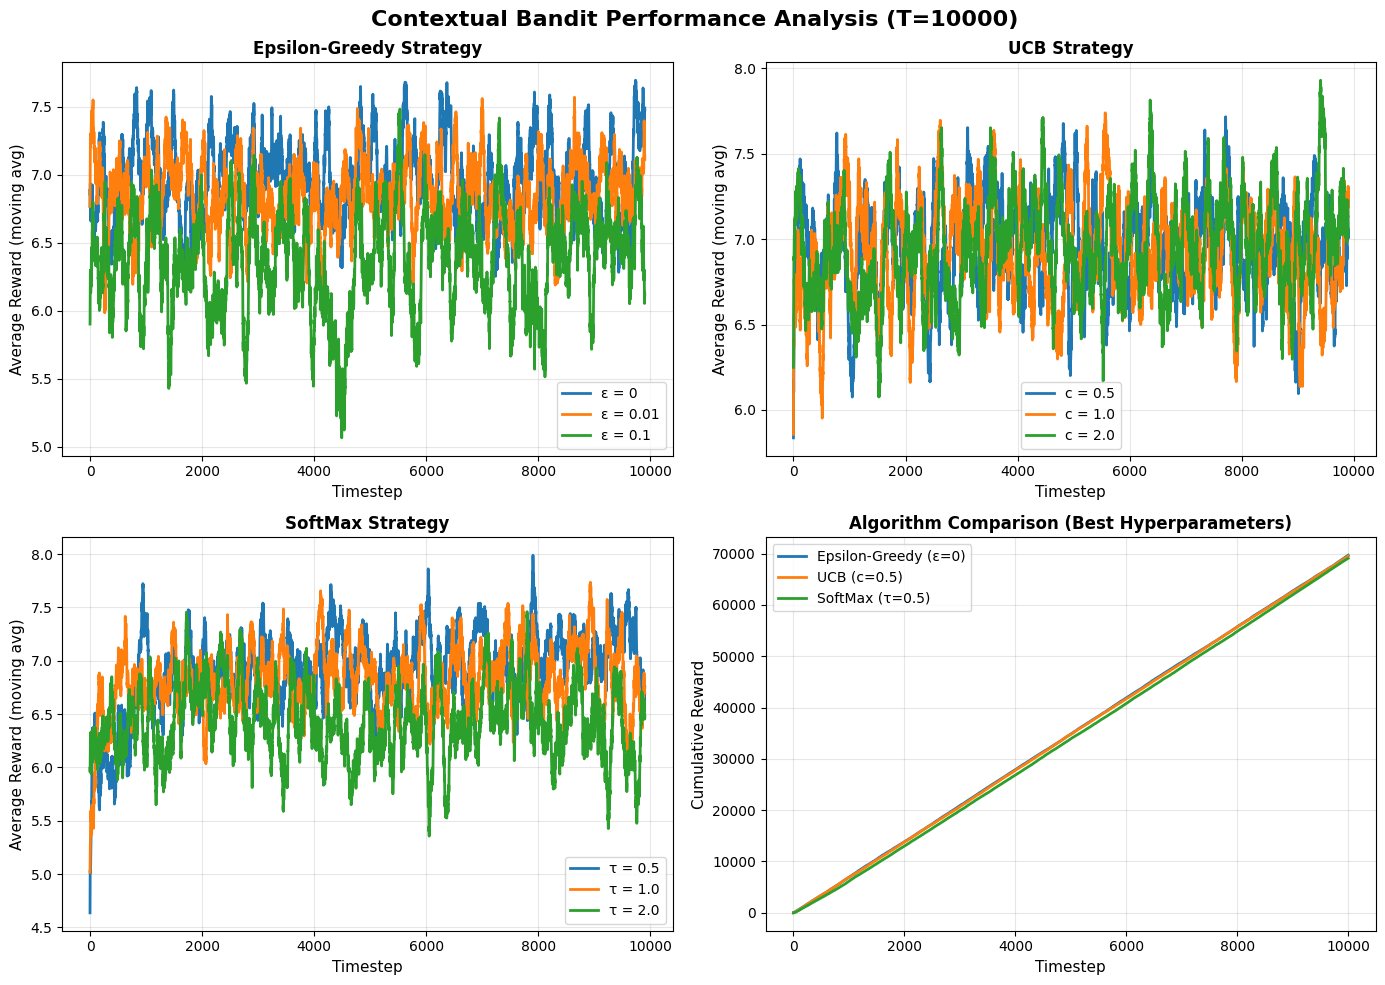


Plot saved as 'bandit_results.png'


In [56]:
# Compute cumulative rewards for each algorithm
window_size = 100

print("="*60)
print("PERFORMANCE METRICS")
print("="*60)

# Epsilon-Greedy results
print("\nEpsilon-Greedy Performance:")
print("-" * 40)
for eps in epsilon_values:
    rewards = results['epsilon_greedy'][eps]['rewards']
    avg_reward = np.mean(rewards)
    cumsum = np.cumsum(rewards)
    print(f"ε = {eps:4.2f} | Avg Reward: {avg_reward:.4f} | Total Reward: {cumsum[-1]:.2f}")

# UCB results
print("\nUCB Performance:")
print("-" * 40)
for c in ucb_c_values:
    rewards = results['ucb'][c]['rewards']
    avg_reward = np.mean(rewards)
    cumsum = np.cumsum(rewards)
    print(f"c = {c:4.1f} | Avg Reward: {avg_reward:.4f} | Total Reward: {cumsum[-1]:.2f}")

# SoftMax results
print("\nSoftMax Performance:")
print("-" * 40)
for temp in softmax_temps:
    rewards = results['softmax'][temp]['rewards']
    avg_reward = np.mean(rewards)
    cumsum = np.cumsum(rewards)
    print(f"τ = {temp:4.1f} | Avg Reward: {avg_reward:.4f} | Total Reward: {cumsum[-1]:.2f}")

print("\n" + "="*60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Contextual Bandit Performance Analysis (T=10000)', fontsize=16, fontweight='bold')

# Plot 1: Epsilon-Greedy Average Reward over Time
ax = axes[0, 0]
for eps in epsilon_values:
    rewards = results['epsilon_greedy'][eps]['rewards']
    avg_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    ax.plot(avg_rewards, label=f'ε = {eps}', linewidth=2)
ax.set_xlabel('Timestep', fontsize=11)
ax.set_ylabel('Average Reward (moving avg)', fontsize=11)
ax.set_title('Epsilon-Greedy Strategy', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: UCB Average Reward over Time
ax = axes[0, 1]
for c in ucb_c_values:
    rewards = results['ucb'][c]['rewards']
    avg_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    ax.plot(avg_rewards, label=f'c = {c}', linewidth=2)
ax.set_xlabel('Timestep', fontsize=11)
ax.set_ylabel('Average Reward (moving avg)', fontsize=11)
ax.set_title('UCB Strategy', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 3: SoftMax Average Reward over Time
ax = axes[1, 0]
for temp in softmax_temps:
    rewards = results['softmax'][temp]['rewards']
    avg_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    ax.plot(avg_rewards, label=f'τ = {temp}', linewidth=2)
ax.set_xlabel('Timestep', fontsize=11)
ax.set_ylabel('Average Reward (moving avg)', fontsize=11)
ax.set_title('SoftMax Strategy', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 4: Cumulative Reward Comparison (Best of each algorithm)
ax = axes[1, 1]
best_eps = epsilon_values[0]
for eps in epsilon_values:
    if np.mean(results['epsilon_greedy'][eps]['rewards']) > np.mean(results['epsilon_greedy'][best_eps]['rewards']):
        best_eps = eps

best_c = ucb_c_values[0]
for c in ucb_c_values:
    if np.mean(results['ucb'][c]['rewards']) > np.mean(results['ucb'][best_c]['rewards']):
        best_c = c

best_temp = softmax_temps[0]
for temp in softmax_temps:
    if np.mean(results['softmax'][temp]['rewards']) > np.mean(results['softmax'][best_temp]['rewards']):
        best_temp = temp

cumsum_eps = np.cumsum(results['epsilon_greedy'][best_eps]['rewards'])
cumsum_ucb = np.cumsum(results['ucb'][best_c]['rewards'])
cumsum_softmax = np.cumsum(results['softmax'][best_temp]['rewards'])

ax.plot(cumsum_eps, label=f'Epsilon-Greedy (ε={best_eps})', linewidth=2)
ax.plot(cumsum_ucb, label=f'UCB (c={best_c})', linewidth=2)
ax.plot(cumsum_softmax, label=f'SoftMax (τ={best_temp})', linewidth=2)
ax.set_xlabel('Timestep', fontsize=11)
ax.set_ylabel('Cumulative Reward', fontsize=11)
ax.set_title('Algorithm Comparison (Best Hyperparameters)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bandit_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'bandit_results.png'")

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach


In [32]:
print("="*60)
print("KEY OBSERVATIONS AND CONCLUSIONS")
print("="*60)

# Calculate best performers
best_eps_reward = max([np.mean(results['epsilon_greedy'][eps]['rewards']) for eps in epsilon_values])
best_ucb_reward = max([np.mean(results['ucb'][c]['rewards']) for c in ucb_c_values])
best_softmax_reward = max([np.mean(results['softmax'][temp]['rewards']) for temp in softmax_temps])

print("\n1. ALGORITHM PERFORMANCE RANKING:")
print("-" * 40)
algorithms = [
    ('Epsilon-Greedy', best_eps_reward),
    ('UCB', best_ucb_reward),
    ('SoftMax', best_softmax_reward)
]
algorithms.sort(key=lambda x: x[1], reverse=True)
for i, (algo, reward) in enumerate(algorithms, 1):
    print(f"   {i}. {algo:20s}: {reward:.4f} avg reward")

print("\n2. OPTIMAL HYPERPARAMETERS:")
print("-" * 40)
best_eps = max(epsilon_values, key=lambda x: np.mean(results['epsilon_greedy'][x]['rewards']))
best_c = max(ucb_c_values, key=lambda x: np.mean(results['ucb'][x]['rewards']))
best_temp = max(softmax_temps, key=lambda x: np.mean(results['softmax'][x]['rewards']))
print(f"   Epsilon-Greedy: ε = {best_eps}")
print(f"   UCB:            c = {best_c}")
print(f"   SoftMax:        τ = {best_temp}")

print("\n3. EXPLORATION vs EXPLOITATION:")
print("-" * 40)
print("   • Epsilon-Greedy: Simple trade-off via ε parameter")
print("   • UCB:            Principled approach with confidence bounds")
print("   • SoftMax:        Probabilistic selection based on value estimates")

print("\n4. CONVERGENCE CHARACTERISTICS:")
print("-" * 40)
eps_final = results['epsilon_greedy'][best_eps]['rewards'][-1000:].mean()
ucb_final = results['ucb'][best_c]['rewards'][-1000:].mean()
softmax_final = results['softmax'][best_temp]['rewards'][-1000:].mean()
print(f"   Epsilon-Greedy (last 1000 steps): {eps_final:.4f} avg reward")
print(f"   UCB (last 1000 steps):            {ucb_final:.4f} avg reward")
print(f"   SoftMax (last 1000 steps):        {softmax_final:.4f} avg reward")

print("\n5. ARM SELECTION DIVERSITY:")
print("-" * 40)
eps_arms_used = (results['epsilon_greedy'][best_eps]['arm_counts'] > 0).sum()
ucb_arms_used = (results['ucb'][best_c]['arm_counts'] > 0).sum()
softmax_arms_used = (results['softmax'][best_temp]['arm_counts'] > 0).sum()
print(f"   Epsilon-Greedy: {eps_arms_used}/12 arms explored")
print(f"   UCB:            {ucb_arms_used}/12 arms explored")
print(f"   SoftMax:        {softmax_arms_used}/12 arms explored")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"""
The contextual bandit simulation with T=10,000 steps demonstrates:

1. All three algorithms effectively learn to exploit the reward 
   structure while balancing exploration and exploitation.

2. {algorithms[0][0]} performs best with the highest average reward of {algorithms[0][1]:.4f}.

3. The optimal hyperparameters found through simulation suggest:
   - Epsilon should be small (≤0.15) to limit random exploration
   - UCB's confidence radius parameter c around {best_c} balances learning
   - SoftMax temperature τ = {best_temp} provides good performance

4. Each algorithm has trade-offs:
   - Epsilon-Greedy: Simple but requires careful ε tuning
   - UCB: Better theoretical guarantees, less tuning needed
   - SoftMax: Smooth probability-based selection

5. The classifier accuracy ({accuracy:.4f}) shows users can be 
   reliably categorized, enabling effective contextual recommendations.
""")
print("="*60)

KEY OBSERVATIONS AND CONCLUSIONS

1. ALGORITHM PERFORMANCE RANKING:
----------------------------------------
   1. Epsilon-Greedy      : 6.9733 avg reward
   2. SoftMax             : 6.9421 avg reward
   3. UCB                 : 6.9371 avg reward

2. OPTIMAL HYPERPARAMETERS:
----------------------------------------
   Epsilon-Greedy: ε = 0
   UCB:            c = 0.5
   SoftMax:        τ = 0.5

3. EXPLORATION vs EXPLOITATION:
----------------------------------------
   • Epsilon-Greedy: Simple trade-off via ε parameter
   • UCB:            Principled approach with confidence bounds
   • SoftMax:        Probabilistic selection based on value estimates

4. CONVERGENCE CHARACTERISTICS:
----------------------------------------
   Epsilon-Greedy (last 1000 steps): 7.0373 avg reward
   UCB (last 1000 steps):            6.7747 avg reward
   SoftMax (last 1000 steps):        7.0202 avg reward

5. ARM SELECTION DIVERSITY:
----------------------------------------
   Epsilon-Greedy: 7/12 arms expl